In [ ]:
!pip install datasets
!pip install einops
!pip install denoising_diffusion_pytorch

from denoising_diffusion_pytorch import Unet
from inspect import isfunction
from einops import rearrange
from functools import partial
from torch import nn, einsum
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
import random
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 8.8 MB/s 
     |████████████████████████████████| 115 kB 75.7 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 
     |████████████████████████████████| 127 kB 67.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 439 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 12.6 MB/s 


# Fashion MNIST
This dataset is very similar to MNIST, but instead of 10 digits we have 10 types of clothing.

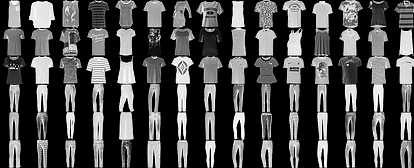

In [ ]:
SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
LR = 1e-3

device = torch.device("cuda")
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = dataloader.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# VAE Architecture
Typically VAEs that operate on images use convolutions and deconvolutions, but in this problem I will simply flatten the input and use an MLP. 

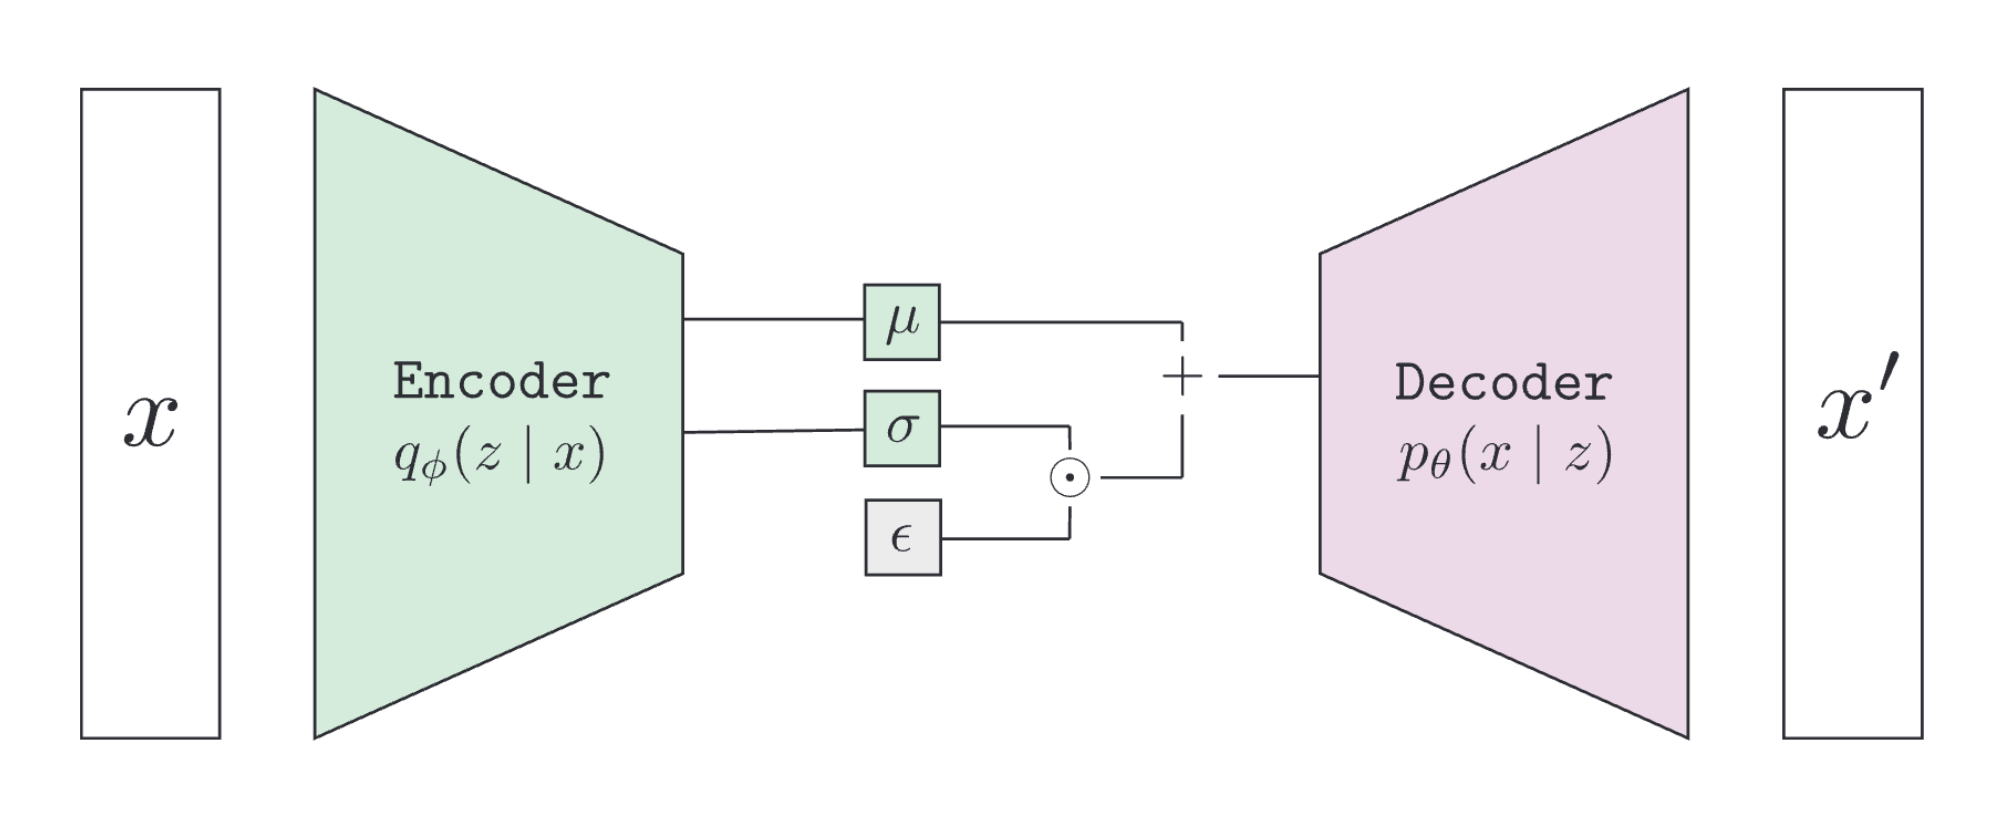



In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dims=4, input_size = 784, num_hidden=128):
        super().__init__()
        self.z_dims = z_dims
        self.input_size = input_size

        # FIXME: Create two encoder layers
        self.encoder = nn.Sequential(
                    nn.Linear(input_size, num_hidden),
                    nn.ReLU(),
                    nn.Linear(num_hidden, num_hidden),
                    nn.ReLU())
        

        self.mu = nn.Linear(num_hidden, z_dims)
        self.logvar = nn.Linear(num_hidden, z_dims)

        self.decoder = nn.Sequential(
                    nn.Linear(z_dims, num_hidden),
                    nn.ReLU(),
                    nn.Linear(num_hidden, num_hidden),
                    nn.ReLU(),
                    nn.Linear(num_hidden, input_size),
                    nn.Sigmoid())

    def forward(self, x):

        mu, logvar = self.mu(self.encoder(x.view(-1, self.input_size))), self.logvar(self.encoder(x.view(-1, self.input_size)))
        std = torch.exp(logvar*0.5)
        eps = torch.randn_like(std)
        z =  mu + eps * std
        
        return self.decoder(z), mu, logvar

The KL Divergence between two gaussians $q_1=\mathcal{N}(\mu_1,\sigma_1)$ and $q_2=\mathcal{N}(\mu_2,\sigma_2)$ is defined as follows:

  $$ D_{\text{KL}}(q_1 \parallel q_2) = log\Big(\frac{\sigma_2}{\sigma_1}\Big) + \frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$


In [ ]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS): 
  model.train()
  train_loss = 0
  for (X, _) in tqdm(train_loader):
      X = X.cuda()
      optimizer.zero_grad()
      x_prime, mu, logvar = model(X)
      
      # Calculate loss
      MSE = nn.MSELoss() 
      loss = 1/2*MSE(x_prime, X.view(-1, x_prime.shape[1])) * X.shape[0] *28*28 + torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
      # print(loss)
              
      loss.backward()
      train_loss += loss.item()
      optimizer.step()

  print('Epoch: {} Train Loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

100%|██████████| 469/469 [00:18<00:00, 24.69it/s]


Epoch: 0 Train Loss: 23.7417


100%|██████████| 469/469 [00:07<00:00, 60.17it/s]


Epoch: 1 Train Loss: 18.1830


100%|██████████| 469/469 [00:06<00:00, 69.20it/s]


Epoch: 2 Train Loss: 16.8019


100%|██████████| 469/469 [00:06<00:00, 68.62it/s]


Epoch: 3 Train Loss: 16.1097


100%|██████████| 469/469 [00:06<00:00, 69.77it/s]


Epoch: 4 Train Loss: 15.8607


100%|██████████| 469/469 [00:06<00:00, 68.93it/s]


Epoch: 5 Train Loss: 15.7149


100%|██████████| 469/469 [00:06<00:00, 69.17it/s]


Epoch: 6 Train Loss: 15.5974


100%|██████████| 469/469 [00:07<00:00, 61.08it/s]


Epoch: 7 Train Loss: 15.5213


100%|██████████| 469/469 [00:06<00:00, 67.19it/s]


Epoch: 8 Train Loss: 15.4522


100%|██████████| 469/469 [00:06<00:00, 69.90it/s]


Epoch: 9 Train Loss: 15.4118


100%|██████████| 469/469 [00:07<00:00, 60.92it/s]


Epoch: 10 Train Loss: 15.3426


100%|██████████| 469/469 [00:06<00:00, 70.96it/s]


Epoch: 11 Train Loss: 15.3122


100%|██████████| 469/469 [00:06<00:00, 69.31it/s]


Epoch: 12 Train Loss: 15.2830


100%|██████████| 469/469 [00:07<00:00, 62.67it/s]


Epoch: 13 Train Loss: 15.2381


100%|██████████| 469/469 [00:06<00:00, 69.63it/s]


Epoch: 14 Train Loss: 15.2224


100%|██████████| 469/469 [00:06<00:00, 70.15it/s]


Epoch: 15 Train Loss: 15.1766


100%|██████████| 469/469 [00:06<00:00, 69.42it/s]


Epoch: 16 Train Loss: 15.1690


100%|██████████| 469/469 [00:06<00:00, 69.14it/s]


Epoch: 17 Train Loss: 15.1559


100%|██████████| 469/469 [00:06<00:00, 69.20it/s]


Epoch: 18 Train Loss: 15.1091


100%|██████████| 469/469 [00:06<00:00, 70.25it/s]

Epoch: 19 Train Loss: 15.1056


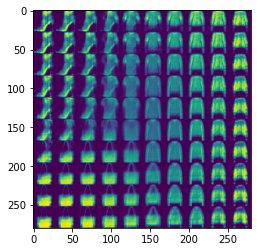

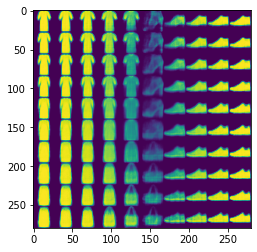

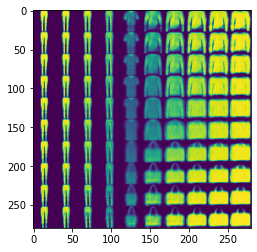

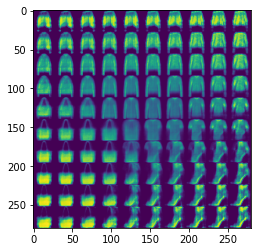

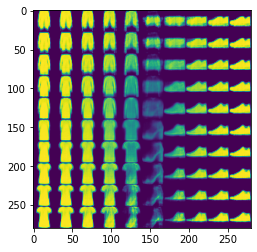

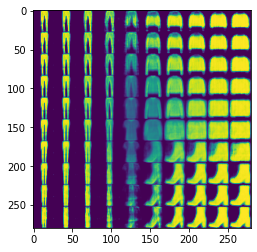

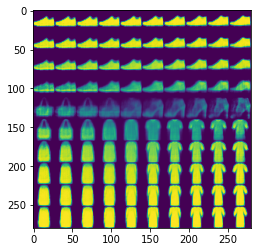

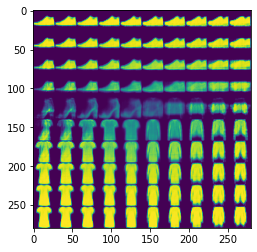

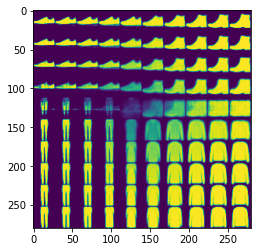

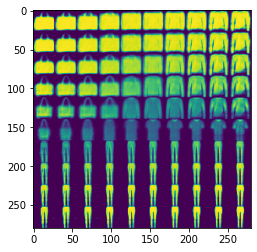

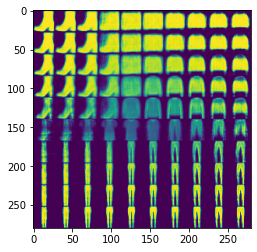

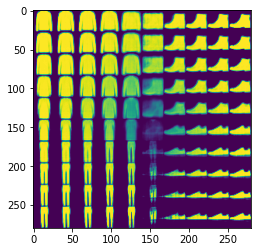

In [ ]:
def plot_latents(model, i=0, j=1):
  # FIXME: Plot the image grid
    w = 28
    img = np.zeros((10*w, 10*w))
    for n, y in enumerate(np.linspace(-5,5, 10)):
        for m, x in enumerate(np.linspace(-5,5, 10)):
            z = torch.Tensor([0,0,0,0]).to(device)
            z[i],z[j] = y,x
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            img[(10-1-n)*w:(10-1-n+1)*w, m*w:(m+1)*w] = x_hat
    plt.imshow(img)
    plt.show()

def plot_zs(model):
  for i in range(model.z_dims):
    for j in range(model.z_dims):
      if i!=j:
        plot_latents(model, i, j)

plot_zs(model)

In [ ]:
#Train and visualize for different betas
def train_beta_vae(model, beta):
  optimizer = optim.Adam(model.parameters(), lr=LR)

  for epoch in range(NUM_EPOCHS): 
    model.train()
    train_loss = 0
    for (X, _) in tqdm(train_loader):
        X = X.cuda()
        optimizer.zero_grad()
        x_prime, mu, logvar = model(X)
        
        # Calculate loss
        MSE = nn.MSELoss() 
        loss = MSE(x_prime, X.view(-1, x_prime.shape[1])) * X.shape[0]*28*28 + beta* torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        # print(loss)
                
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('Epoch: {} Train Loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    

model01 = VAE().cuda()
model1 = VAE().cuda()
model10 = VAE().cuda()
train_beta_vae(model01, beta=0.1)
train_beta_vae(model1, beta=1)
train_beta_vae(model10, beta=10)

100%|██████████| 469/469 [00:07<00:00, 61.41it/s]


Epoch: 0 Train Loss: 36.3198


100%|██████████| 469/469 [00:06<00:00, 69.62it/s]


Epoch: 1 Train Loss: 20.9281


100%|██████████| 469/469 [00:06<00:00, 69.61it/s]


Epoch: 2 Train Loss: 19.4178


100%|██████████| 469/469 [00:06<00:00, 70.01it/s]


Epoch: 3 Train Loss: 18.5761


100%|██████████| 469/469 [00:06<00:00, 69.81it/s]


Epoch: 4 Train Loss: 18.0533


100%|██████████| 469/469 [00:06<00:00, 67.88it/s]


Epoch: 5 Train Loss: 17.7086


100%|██████████| 469/469 [00:07<00:00, 59.23it/s]


Epoch: 6 Train Loss: 17.4443


100%|██████████| 469/469 [00:06<00:00, 68.44it/s]


Epoch: 7 Train Loss: 17.2285


100%|██████████| 469/469 [00:06<00:00, 68.17it/s]


Epoch: 8 Train Loss: 17.0697


100%|██████████| 469/469 [00:06<00:00, 67.20it/s]


Epoch: 9 Train Loss: 16.9133


100%|██████████| 469/469 [00:06<00:00, 70.19it/s]


Epoch: 10 Train Loss: 16.7859


100%|██████████| 469/469 [00:06<00:00, 70.17it/s]


Epoch: 11 Train Loss: 16.6640


100%|██████████| 469/469 [00:06<00:00, 69.54it/s]


Epoch: 12 Train Loss: 16.5796


100%|██████████| 469/469 [00:07<00:00, 61.37it/s]


Epoch: 13 Train Loss: 16.4864


100%|██████████| 469/469 [00:06<00:00, 69.35it/s]


Epoch: 14 Train Loss: 16.4044


100%|██████████| 469/469 [00:06<00:00, 69.01it/s]


Epoch: 15 Train Loss: 16.3360


100%|██████████| 469/469 [00:06<00:00, 68.85it/s]


Epoch: 16 Train Loss: 16.2496


100%|██████████| 469/469 [00:06<00:00, 68.71it/s]


Epoch: 17 Train Loss: 16.2041


100%|██████████| 469/469 [00:06<00:00, 68.86it/s]


Epoch: 18 Train Loss: 16.1520


100%|██████████| 469/469 [00:06<00:00, 69.11it/s]


Epoch: 19 Train Loss: 16.1056


100%|██████████| 469/469 [00:07<00:00, 60.78it/s]


Epoch: 0 Train Loss: 44.1618


100%|██████████| 469/469 [00:06<00:00, 69.05it/s]


Epoch: 1 Train Loss: 30.3773


100%|██████████| 469/469 [00:06<00:00, 68.93it/s]


Epoch: 2 Train Loss: 27.9734


100%|██████████| 469/469 [00:06<00:00, 68.99it/s]


Epoch: 3 Train Loss: 26.5361


100%|██████████| 469/469 [00:06<00:00, 69.89it/s]


Epoch: 4 Train Loss: 26.0065


100%|██████████| 469/469 [00:06<00:00, 69.96it/s]


Epoch: 5 Train Loss: 25.6124


100%|██████████| 469/469 [00:07<00:00, 61.45it/s]


Epoch: 6 Train Loss: 25.3266


100%|██████████| 469/469 [00:06<00:00, 69.92it/s]


Epoch: 7 Train Loss: 25.1338


100%|██████████| 469/469 [00:06<00:00, 68.97it/s]


Epoch: 8 Train Loss: 24.9609


100%|██████████| 469/469 [00:06<00:00, 69.85it/s]


Epoch: 9 Train Loss: 24.8417


100%|██████████| 469/469 [00:06<00:00, 68.79it/s]


Epoch: 10 Train Loss: 24.7329


100%|██████████| 469/469 [00:06<00:00, 68.60it/s]


Epoch: 11 Train Loss: 24.6610


100%|██████████| 469/469 [00:06<00:00, 68.35it/s]


Epoch: 12 Train Loss: 24.5807


100%|██████████| 469/469 [00:07<00:00, 61.40it/s]


Epoch: 13 Train Loss: 24.5316


100%|██████████| 469/469 [00:06<00:00, 69.76it/s]


Epoch: 14 Train Loss: 24.4439


100%|██████████| 469/469 [00:06<00:00, 68.82it/s]


Epoch: 15 Train Loss: 24.3805


100%|██████████| 469/469 [00:06<00:00, 69.25it/s]


Epoch: 16 Train Loss: 24.3446


100%|██████████| 469/469 [00:06<00:00, 69.62it/s]


Epoch: 17 Train Loss: 24.2791


100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch: 18 Train Loss: 24.2461


100%|██████████| 469/469 [00:06<00:00, 68.74it/s]


Epoch: 19 Train Loss: 24.1863


100%|██████████| 469/469 [00:07<00:00, 61.95it/s]


Epoch: 0 Train Loss: 62.7979


100%|██████████| 469/469 [00:06<00:00, 68.69it/s]


Epoch: 1 Train Loss: 54.9479


100%|██████████| 469/469 [00:06<00:00, 68.74it/s]


Epoch: 2 Train Loss: 54.4789


100%|██████████| 469/469 [00:06<00:00, 68.65it/s]


Epoch: 3 Train Loss: 54.2584


100%|██████████| 469/469 [00:06<00:00, 68.63it/s]


Epoch: 4 Train Loss: 54.1846


100%|██████████| 469/469 [00:06<00:00, 69.00it/s]


Epoch: 5 Train Loss: 54.0029


100%|██████████| 469/469 [00:07<00:00, 62.53it/s]


Epoch: 6 Train Loss: 54.0019


100%|██████████| 469/469 [00:06<00:00, 69.94it/s]


Epoch: 7 Train Loss: 53.9020


100%|██████████| 469/469 [00:06<00:00, 69.62it/s]


Epoch: 8 Train Loss: 53.8461


100%|██████████| 469/469 [00:06<00:00, 68.80it/s]


Epoch: 9 Train Loss: 53.8961


100%|██████████| 469/469 [00:06<00:00, 69.51it/s]


Epoch: 10 Train Loss: 53.7530


100%|██████████| 469/469 [00:06<00:00, 68.69it/s]


Epoch: 11 Train Loss: 53.7699


100%|██████████| 469/469 [00:06<00:00, 70.05it/s]


Epoch: 12 Train Loss: 53.7678


100%|██████████| 469/469 [00:07<00:00, 61.06it/s]


Epoch: 13 Train Loss: 53.7233


100%|██████████| 469/469 [00:06<00:00, 69.46it/s]


Epoch: 14 Train Loss: 53.6586


100%|██████████| 469/469 [00:06<00:00, 69.10it/s]


Epoch: 15 Train Loss: 53.6907


100%|██████████| 469/469 [00:06<00:00, 69.27it/s]


Epoch: 16 Train Loss: 53.6269


100%|██████████| 469/469 [00:06<00:00, 69.53it/s]


Epoch: 17 Train Loss: 53.6511


100%|██████████| 469/469 [00:06<00:00, 68.42it/s]


Epoch: 18 Train Loss: 53.6485


100%|██████████| 469/469 [00:06<00:00, 69.28it/s]

Epoch: 19 Train Loss: 53.5749


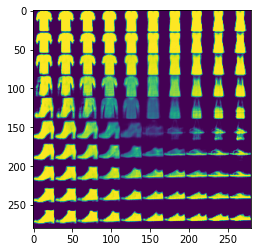

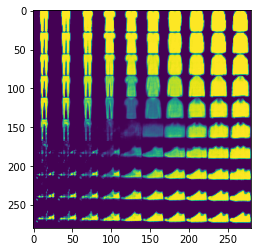

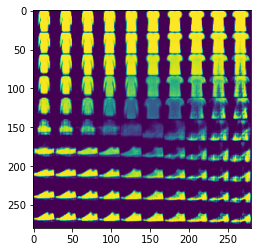

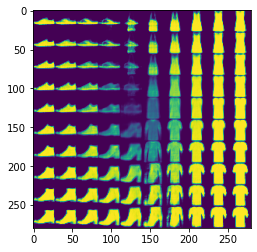

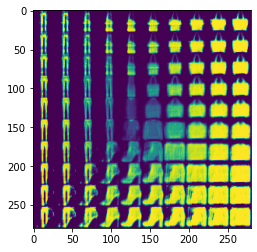

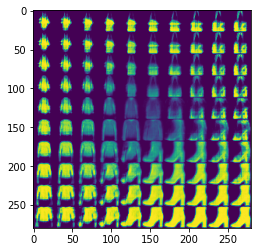

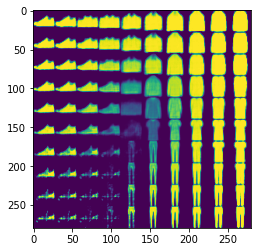

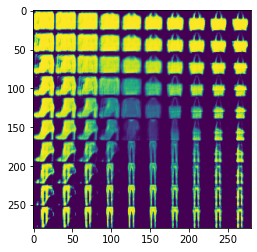

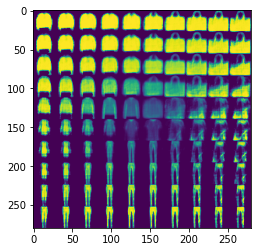

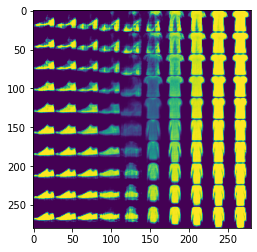

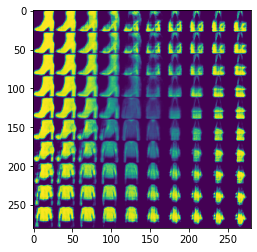

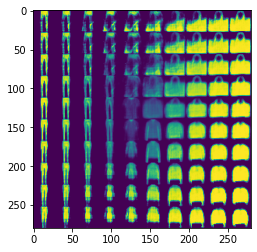

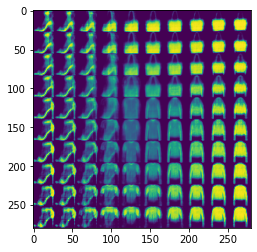

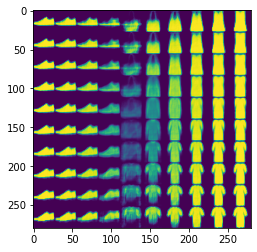

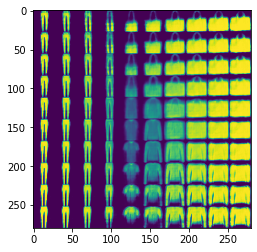

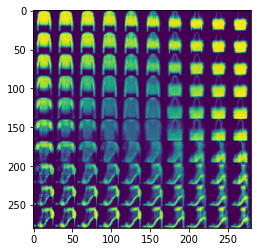

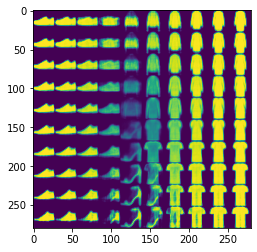

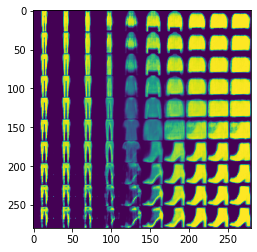

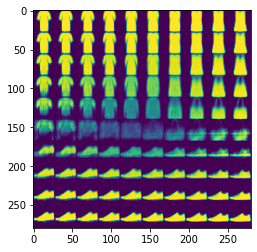

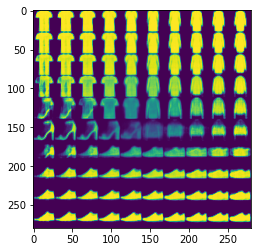

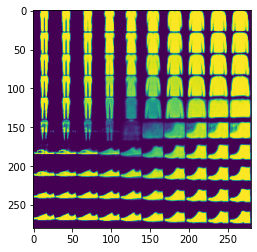

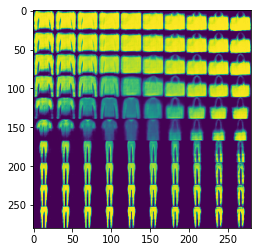

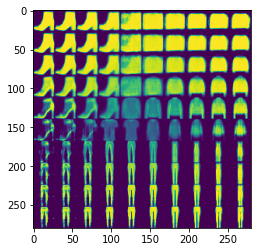

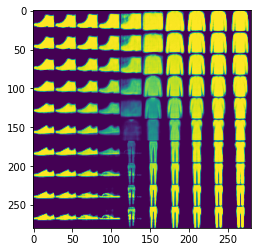

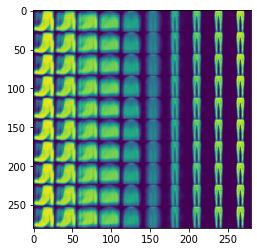

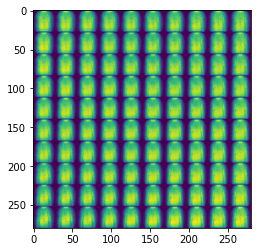

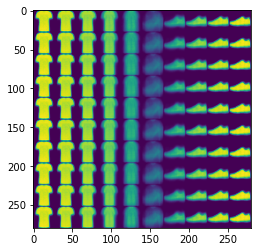

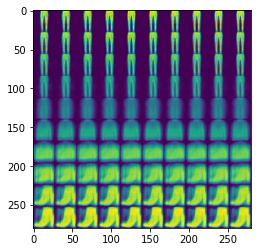

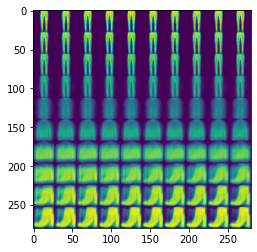

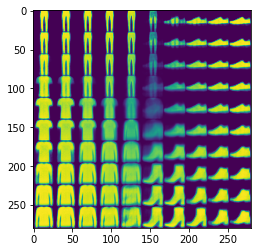

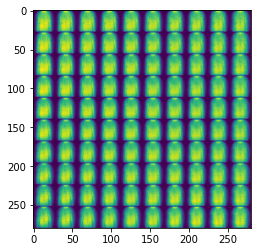

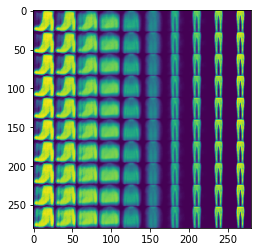

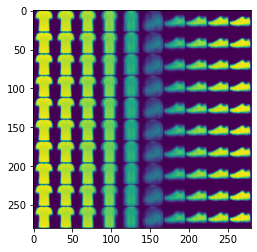

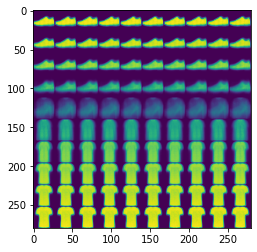

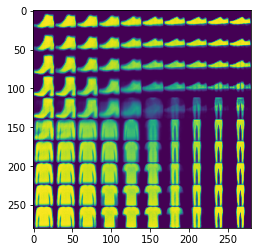

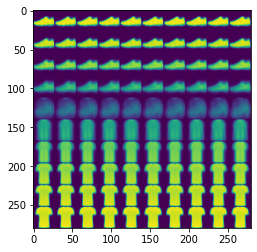

In [ ]:
plot_zs(model01)
plot_zs(model1)
plot_zs(model10)

# Diffusion Models

In [ ]:
NUM_EPOCHS = 5
TOTAL_TIMESTEPS = 200
scaled_size = 32
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)
# Create the Unet model
model = Unet(scaled_size, channels=1, dim_mults=(1, 2, 4,)).to(device)

# We will use the following variance schedule for our diffusion model
beta = torch.linspace(0.0001, 0.02, TOTAL_TIMESTEPS)


def forward_sample(x_0, t, e):
    # calculate x_t from x_0, e, and t using your equation from question 
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, axis=0).to(device)
    mean = gather(alpha_hat, t) ** 0.5 * x_0
    variance = 1 - gather(alpha_hat, t)
    
    return mean + (variance**0.5)*e

optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(NUM_EPOCHS):
    train_losses = []
    for (X, y) in tqdm(train_loader):
      optimizer.zero_grad()
      batch_size = X.shape[0]
      batch = X.to(device)

      # Sample a batch of times for training
      t = torch.randint(0, TOTAL_TIMESTEPS, (batch_size,), device=device).long()

      # Calculate the loss
      e = torch.randn_like(batch).to(device)
      x_t = forward_sample(batch, t, e).to(device)
      e_pred = model(x_t, t)
      loss = F.mse_loss(e, e_pred)
      
      # Gradient step
      train_losses.append(loss.item())
      loss.backward()
      optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, np.mean(train_losses)))

100%|██████████| 469/469 [01:42<00:00,  4.58it/s]


Epoch: 0 Loss: 0.09732433491900785


100%|██████████| 469/469 [01:37<00:00,  4.79it/s]


Epoch: 1 Loss: 0.06108507738788245


100%|██████████| 469/469 [01:34<00:00,  4.95it/s]


Epoch: 2 Loss: 0.055555893652347615


100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Epoch: 3 Loss: 0.05300142887685853


100%|██████████| 469/469 [01:34<00:00,  4.96it/s]

Epoch: 4 Loss: 0.052136906619265136


## Denoising with the learned model

In [ ]:
def reverse_sample(model, x, t):

    # Using beta_t, calculate beta_tilde_t using equation 5 from the pset document
    alpha = 1. - beta
    alpha_hat = torch.cumprod(alpha, dim=0).to(device)
    alpha_hat_prev = F.pad(alpha_hat[:-1], (1, 0), value = 1.).to(device)
    alpha_hat_t = gather(alpha_hat.to(device), t)
    alpha_t = gather(alpha.to(device), t)
    alpha_hat_prev_t = gather(alpha_hat_prev.to(device),t)
    beta_tilde_t = (1. - alpha_hat_prev_t.to(device))/(1. - alpha_hat_t.to(device)) * gather(beta.to(device),t)


    # Using beta, calculate mu_tilde_t using equation 6 from the pset document
    eps_coef = ((1 - alpha_t) / (1 - alpha_hat_t) ** .5).to(device)
    mu_tilde_t = 1 / (alpha_t ** 0.5) * (x - eps_coef * model(x, t))

    e = torch.randn_like(x)
    return mu_tilde_t + torch.sqrt(beta_tilde_t) * e 

@torch.no_grad()
def sample(model):
    shape = (1, 1, scaled_size, scaled_size)
    img = torch.randn(shape, device=device)
    imgs = [img.cpu().numpy()]
    for i in reversed(range(0, TOTAL_TIMESTEPS)):
        img = reverse_sample(model, img, torch.full((shape[0],), i, device=device, dtype=torch.long))
        imgs.append(img.cpu().numpy())
    return imgs

In [ ]:
shape = (1, 1, scaled_size, scaled_size)
i = 1
torch.full((shape[0],), i, device=device, dtype=torch.long)

tensor([1], device='cuda:0')

Create a plot with six horizontally-aligned subfigures showing the diffusion model inference $x_t$ for $t\in{\{200, 100, 50, 20, 10, 0\}}$.

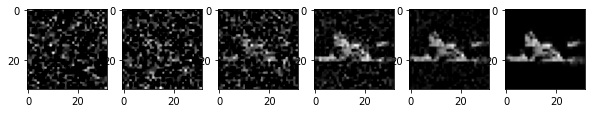

In [ ]:
samples = sample(model)
# FIXME: Plot the model inference over time using the samples calculated above
fig,ax = plt.subplots(1,6,figsize = (10,2))
for i,t in enumerate([0,100,150,180,190,200]):
  ax[i].imshow(samples[t][0,0,:,:],cmap='gray', vmin=0)